In [1]:
from scipy import integrate
import matplotlib.pyplot as plt
import numpy as np
import torch
from pygad import torchga
import pygad
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import os
import glob

files = glob.glob(r'C:\Files\ProjMan\trajectory\*')
#for f in files:
#    os.remove(f)
files = glob.glob(r'C:\Files\ProjMan\upr\*')
#for f in files:
#    os.remove(f)
files = glob.glob(r'C:\Files\ProjMan\models\*')
#for f in files:
#    os.remove(f)

In [3]:
#Система дифференциальных уравнений
def dydt(t, y, p):
    d=np.zeros(len(y))                                        #массив значений производных
    d[0]=y[1]                                                 #dx
    d[1]=-y[0]*p[0]/((y[0]**2+y[2]**2)**1.5)+y[5]*np.sin(y[4])#dvx
    d[2]=y[3]                                                 #dy
    d[3]=-y[2]*p[0]/((y[0]**2+y[2]**2)**1.5)+y[5]*np.cos(y[4])#dvy
    d[4]=y[6]                                                 #dfi
    return d

#def event_h_eq_0(t, y):
#        return y[1]

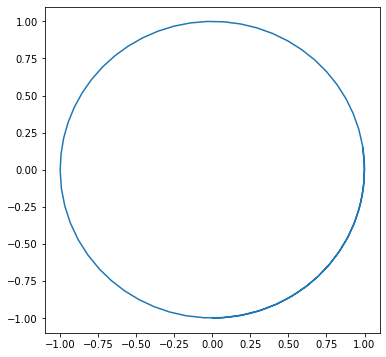

In [4]:
#тест системы
tk=8.0
nc=[0.,1,-1.,0.,0.]
params=[1]
sol=integrate.solve_ivp(lambda t, y: dydt(t, y, params), [0., tk],
                            np.append(nc, [0.,0.]),
                            method='BDF', rtol=1e-10)
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(sol.y[0],sol.y[2])#sol.t,(sol.y[1]**2+sol.y[3]**2)**0.5

In [5]:
params=[5.972*6.6743*1e13] #Указываем начальные параметры
R=6371000.0+100000.0
tnm=10.0
tkm=50.0
dv=+20
tm=30.0
tn=0
tk=100.0
dt=0.1
pock=0
fi=0
ncp=np.array([0.,np.sqrt(params[0]/R),-R,0.,0.])
print(ncp)

[       0.             7848.32649122 -6471000.                0.
        0.        ]


In [6]:
#расчитываем маневр при помощи мгновенного приращения импульса
tr=0.0
nc=ncp.copy()
idl=[nc]
while tr<tk:
    sol=integrate.solve_ivp(lambda t, y: dydt(t, y, params), [0., dt],
                            np.append(nc, [0.,0.]),
                            method='RK45', rtol=1e-2)
    nc=np.array([sol.y[:-2][i][-1] for i in range(len(sol.y[:-2]))])
    tr+=dt
    if abs(tr-tm)<dt/10:
        nc+=np.array([0,dv*sol.y[2][-1]/((sol.y[0][-1]**2+sol.y[2][-1]**2)**0.5),
                      0,dv*sol.y[0][-1]/((sol.y[0][-1]**2+sol.y[2][-1]**2)**0.5),0])
        fi=np.arctan2(sol.y[2][-1],sol.y[0][-1])
    idl=np.append(idl,[nc],axis=0)
nrm=np.array([R,np.sqrt(params[0]/R),R,np.sqrt(params[0]/R),fi])

In [7]:
fi, idl[0]

(-1.534410946677995,
 array([       0.        ,     7848.32649122, -6471000.        ,
               0.        ,        0.        ]))

In [8]:
tr=0.0
ncp[-1]=fi
nc=ncp.copy()
ni=[nc]
while tr<tk:
    sol=integrate.solve_ivp(lambda t, y: dydt(t, y, params), [0., dt],
                            np.append(nc, [(1. if abs(tr-tm)<abs(dv/2) else 0.),0.]),
                            method='RK45', rtol=1e-2)
    nc=np.array([sol.y[:-2][i][-1] for i in range(len(sol.y[:-2]))])
    tr+=dt
    ni=np.append(ni,[nc],axis=0)

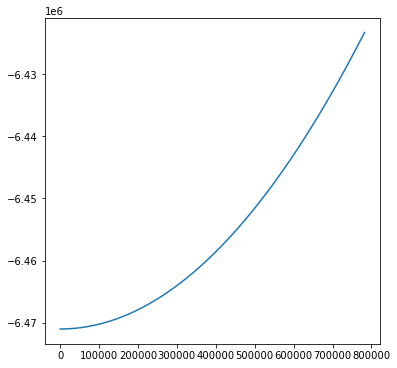

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
an=np.rot90(idl,3)
ax.plot(an[0],an[2])

In [10]:
np.rot90(idl)

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  9.51881140e-01,  1.90376227e+00, ...,
         9.49356865e+02,  9.50301849e+02,  9.51246820e+02],
       [-6.47100000e+06, -6.47099995e+06, -6.47099981e+06, ...,
        -6.42350779e+06, -6.42341281e+06, -6.42331773e+06],
       [ 7.84832649e+03,  7.84832643e+03,  7.84832626e+03, ...,
         7.77087042e+03,  7.77075551e+03,  7.77064048e+03],
       [ 0.00000000e+00,  7.84832647e+02,  1.56966528e+03, ...,
         7.80735400e+05,  7.81512481e+05,  7.82289551e+05]])

24.487500070115434
[0.034035080461762846, 0.00048429585876874626, 0.006228607147932053, 8.917823186038731e-05]


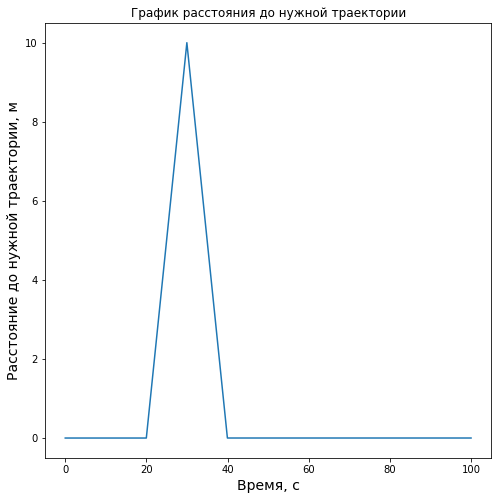

In [11]:
fig2, ax2 = plt.subplots(figsize=(8, 8))
ax2.set_xlabel('Время, с',fontsize=14)
ax2.set_ylabel('Расстояние до нужной траектории, м',fontsize=14)
ax2.set_title('График расстояния до нужной траектории')
an2=np.rot90(ni,3)
ax2.plot(np.linspace(tk,tn,len(an2[0])),((an[1]-an2[1])**2+(an[3]-an2[3])**2)**0.5)
print(1/sum([abs(an[i][0]-an2[i][0]) for i in range(4)]))
print([abs(an[i][0]-an2[i][0]) for i in range(4)])
#ax2.plot(an2[0],an2[2])

In [12]:
model = torch.nn.Sequential(torch.nn.Linear(6, 10),
                            torch.nn.Linear(10, 100),
                            torch.nn.Linear(100, 100),
                            torch.nn.Sigmoid(),
                            torch.nn.Linear(100, 100),
                            torch.nn.Sigmoid(),
                            torch.nn.Linear(100, 10),
#                            torch.nn.Sigmoid(),
#                            torch.nn.Linear(100, 100),
#                            torch.nn.Linear(100, 100),
#                            torch.nn.Linear(100, 100),
#                            torch.nn.Linear(100, 100),
#                            torch.nn.Linear(100, 100),
#                            torch.nn.Linear(100, 100),
#                            torch.nn.Sigmoid(),
                            torch.nn.Linear(10, 2),
                            torch.nn.Hardtanh(0,2))

In [13]:
model(torch.tensor([0.,1.,0.,1.,-1,0],dtype=torch.float32))

tensor([0.0000, 0.0072], grad_fn=<HardtanhBackward0>)

In [14]:
def svresults(ga_instance):
    global torch_ga, model, idl, dt,tk,tm,nc,tnm,tkm,pock,fi,params,nrm,dv
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    best_solution_weights = torchga.model_weights_as_dict(model=model,
                                                      weights_vector=solution)
    model.load_state_dict(best_solution_weights)
    #выводим промежуточные результаты
    nc=ncp.copy()
    ans2=[nc]
    tr=0
    ans=np.array([[],[],[],[],[],[],[],[]])
    try:
        while tr<tk:
            md=model(torch.tensor(np.append((nc-idl[round(tr/dt)])/nrm,[(tr-tm)/abs(dv/2)]),
                                  dtype=torch.float32)).detach().numpy()
            sol=integrate.solve_ivp(lambda t, y: dydt(t, y, params), [0., dt],
                            np.append(nc, [(round(md[0]/2) if tkm>=tr>=tnm else 0),
                                                                  (round(md[1])-1 if tkm>=tr>=tnm else 0)*0]),
                             method='RK45', rtol=1e-2)
            nc=[sol.y[0][-1],sol.y[1][-1],sol.y[2][-1],sol.y[3][-1],sol.y[4][-1]%(2*np.pi)]
            ans2=np.append(ans2,[np.array([sol.y[:-2][i][-1] for i in range(len(sol.y[:-2]))])],axis=0)
            ans=np.array([np.append(ans[0],sol.t+tr),np.append(ans[1],sol.y[0]),np.append(ans[2],sol.y[1]),
                np.append(ans[3],sol.y[2]),
                np.append(ans[4],sol.y[3]),np.append(ans[5],sol.y[4]),np.append(ans[6],sol.y[5]),np.append(ans[7],sol.y[6])])
            tr+=dt
    except:
            print('bad p')
            return
    fig, ax = plt.subplots(figsize=(8, 8))
    fig3, ax3 = plt.subplots(figsize=(8, 8))
    
    ax.set_xlabel('Ось x, м',fontsize=14)
    ax.set_ylabel('ось y, м',fontsize=14)
    ax.set_title('Трактория полета')
    ax.set_ylim([np.min([np.min(ans[1]),np.min(ans[3])]),np.max([np.max(ans[1]),np.max(ans[3])])])
    ax.set_xlim([np.min([np.min(ans[1]),np.min(ans[3])]),np.max([np.max(ans[1]),np.max(ans[3])])])
    ax.plot(ans[1], ans[3])
    
    ax3.set_xlabel('Время, с',fontsize=14)
    ax3.set_ylabel('Расстояние до нужной траектории, м',fontsize=14)
    ax3.set_title('График расстояния до нужной траектории')
    ax3.plot(np.linspace(tn,tk,len(ans2)),
             ((np.rot90(idl)[-1]-np.rot90(ans2)[-1])**2+(np.rot90(idl)[-3]-np.rot90(ans2)[-3])**2)**0.5)
    
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    ax1.set_ylim([-0.1, 1.1])
    ax2.set_ylim([-1.1, 1.1])
    
    ax1.set_xlabel('Время, с',fontsize=14)
    ax1.set_ylabel('Включение двигателя',fontsize=14)
    ax1.set_title('График включения двигателя')
    ax1.plot(ans[0],ans[6])
    
    ax2.set_xlabel('Время, с',fontsize=14)
    ax2.set_ylabel('Угловая скорость аппарата, рад/с',fontsize=14)
    ax2.set_title('График угловой скорости аппарата')
    ax2.plot(ans[0],ans[7])
    fig.savefig(r"C:\Files\ProjMan\trajectory\{generation}t.png".format(generation=ga_instance.generations_completed+pock*10))
    fig3.savefig(r"C:\Files\ProjMan\trajectory\{generation}dt.png".format(generation=ga_instance.generations_completed+pock*10))
    fig1.savefig(r"C:\Files\ProjMan\upr\{generation}d.png".format(generation=ga_instance.generations_completed+pock*10))
    fig2.savefig(r"C:\Files\ProjMan\upr\{generation}r.png".format(generation=ga_instance.generations_completed+pock*10))
    plt.close(fig)
    plt.close(fig1)
    plt.close(fig2)
    plt.close(fig3)

In [15]:
def fitness_func(solution, sol_idx):
    global torch_ga, model, idl, dt,tk,tm,nc,tnm,tkm,fi,params,dv,nrm

    model_weights_dict = torchga.model_weights_as_dict(model=model,
                                                       weights_vector=solution)
    model.load_state_dict(model_weights_dict)
    nc=ncp.copy()
    tr=tnm
    ans=[]
    try:
        #считаем до точки начала маневра
        sol=integrate.solve_ivp(lambda t, y: dydt(t, y, params), [0., tnm],np.append(nc,[0,0]),method='RK45', rtol=1e-2)
        nc=[sol.y[0][-1],sol.y[1][-1],sol.y[2][-1],sol.y[3][-1],(sol.y[4][-1])%(2*np.pi)]
        while tr<tkm:                                                                     #считаем сам менвр
            md=model(torch.tensor(np.append((nc-idl[round(tr/dt)])/nrm,[(tr-tm)/abs(dv/2)]), 
                                  dtype=torch.float32)).detach().numpy()
            sol=integrate.solve_ivp(lambda t, y: dydt(t, y, params), [0., dt],
                                np.append(nc,[round(md[0]/2),(round(md[1])-1)*0]), method='RK45', rtol=1e-2)
            nc=[sol.y[0][-1],sol.y[1][-1],sol.y[2][-1],sol.y[3][-1],(sol.y[4][-1])%(2*np.pi)]
            tr+=dt
        #считаем после окончания маневра
        sol=integrate.solve_ivp(lambda t, y: dydt(t, y, params), [0., tk-tkm],np.append(nc,[0,0]),method='RK45', rtol=1e-2)
        ans=np.array([sol.y[0][-1],sol.y[1][-1],sol.y[2][-1],sol.y[3][-1],0])
    except:
        print('bad sol:',sol_idx)
        return -1
    #оценка решения, то есть схожести орбит
    abs_error = np.sum(np.abs(ans-idl[-1]))
    solution_fitness = 1.0 / abs_error
    try:
        pass
        #if ((sol_idx+1)%25==0):
        #    print(sol_idx,solution_fitness,abs_error)
    except:
        pass
    return solution_fitness

def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    svresults(ga_instance)

In [16]:
num_generations = 10 # Количество поколений
num_parents_mating = 25 # Количество родителей в каждом поколении
parent_selection_type = "sss" # Способ выюора родителя
crossover_type = "scattered" # Способ скрещивания
mutation_type = "adaptive" # Способ мутации
mutation_probability = [1.0,0.4] # Вероятность мутации
mutation_percent_genes = [100,100]
keep_parents = -1 # Количество родителей, которые остануться в следующем поколении (-1 -все, кого не заменят потомки)

In [ ]:
for pock in range(100):
    torch_ga = torchga.TorchGA(model=model,
                           num_solutions=50)
    initial_population = torch_ga.population_weights
    ga_instance = pygad.GA(num_generations=num_generations, 
                       num_parents_mating=num_parents_mating, 
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       parent_selection_type=parent_selection_type,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_probability=mutation_probability,
                       mutation_percent_genes=mutation_percent_genes,
                       keep_parents=keep_parents,
                       on_generation=callback_generation)
    print('start',pock)
    ga_instance.run()
    #Сохраняем промежуточныйе результаты
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    best_solution_weights = torchga.model_weights_as_dict(model=model,
                                                      weights_vector=solution)
    model.load_state_dict(best_solution_weights)
    torch.save(model.state_dict(), r"C:\Files\ProjMan\models\{generation}.pt".format(generation=(pock+1)*10))

start 0
Generation = 1
Fitness    = 0.006122435327184939
Generation = 2
Fitness    = 0.007248844092431797
Generation = 3
Fitness    = 0.007248844092431797
Generation = 4
Fitness    = 0.007248844092431797
Generation = 5
Fitness    = 0.007248844092431797
Generation = 6
Fitness    = 0.007248844092431797
Generation = 7
Fitness    = 0.007248844092431797
Generation = 8
Fitness    = 0.007248844092431797
Generation = 9
Fitness    = 0.007248844092431797
Generation = 10
Fitness    = 0.007248844092431797
start 1
Generation = 1
Fitness    = 0.007389195422619606
Generation = 2
Fitness    = 0.007389195422619606
Generation = 3
Fitness    = 0.007389195422619606
Generation = 4
Fitness    = 0.007389195422619606
Generation = 5
Fitness    = 0.007389195422619606
Generation = 6
Fitness    = 0.007389195422619606
Generation = 7
Fitness    = 0.007389195422619606
Generation = 8
Fitness    = 0.007389195422619606
Generation = 9
Fitness    = 0.007389195422619606
Generation = 10
Fitness    = 0.007389195422619606
st

In [ ]:
#видно, что после 26-го поколения процесс улучшения стопориться, то есть был найден локальный минимум из котрого
#программа не может выбраться. Поэтому сейчас ведется работа над алгоритмом предобучения.